<a href="https://colab.research.google.com/github/Bryan6aero/New-Chinese-Classifier/blob/main/Chinese_News_Story_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
Hello. This is an example of a classifier that utilizes BERT (Bidirectional Encoder Representations from Transformers) to classify Chinese text.  

To demonstrate this task, I acquired a dataset from Kaggle consisting of thousands of news articles in Chinese.  These articles fall into three broad classes, domestic, international, and other news.  


The following sections of code 
   1. Install the necessary environment and libraries to run classifier.
   2. Download the data the model will be trained on and tested against.
   3. Format the training data into a format BERT can understand and split of 10% of the training data to create a validation dataset that the model can be tested against when it is training.
   4. Train the model and evaluate its accuracy against the validation dataset.
   5. Use the trained model to classify new data and evaluate its accuracy. 

## 1 Install Environment and Libraries

### 1.1 Install the Hugging Face Library


In [1]:
!pip install transformers

### 1.2 BERT For**Multi-Class**SequenceClassification

In [2]:
from torch import nn
from torch.nn import BCEWithLogitsLoss
from transformers import BertPreTrainedModel, BertModel

class BertForSequenceClassification(BertPreTrainedModel):

    def __init__(self, config):
        '''
        Class initializer, called when we create a new instance of this class.
        '''

        # Call the init function of the parent class (BertPreTrainedModel)        
        super().__init__(config)
       
        # Store the number of labels.
        self.num_labels = config.num_labels
        
        # Create a `BertModel`--this implements all of BERT except for the final
        # task-specific output layer (which is what we'll do here in `forward`). 
        self.bert = BertModel(config)

        # Setup dropout object (note: I'm not familiar enough to speak to this).
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # Create a [768 x 6] weight matrix to use as our classifier.
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize model weights (inherited function).
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        '''
        This function defines what happens on a forward pass of our model, both
        for training and evaluation. For example, when we call 
            `model(b_input_ids, ...)`
        during our training loop, it results in a call to this `forward`
        function.
        '''

        # ====================
        #   Run Through BERT
        # ====================

        # All of BERT's (non-task-specific) architecture is implemented by the
        # BertModel class. Here we pass all of the inputs through our BertModel
        # instance. 
        outputs = self.bert(
            input_ids,                      # The input sequence
            attention_mask=attention_mask,  # Mask out any [PAD] tokens.
            token_type_ids=token_type_ids,  # Identify segment A vs. B
            position_ids=position_ids,      # TODO...
            head_mask=head_mask,            # TODO...
            inputs_embeds=inputs_embeds,    # Presumably the initial embeddings
                                            # for the tokens in our sequence.
            output_attentions=output_attentions, # Boolean, whether to return
                                                 # all of the attention scores.
            output_hidden_states=output_hidden_states, # Whether to return
                                                       # embeddings from all 12
                                                       # layers.
        )

        # Side note: It confused me to see us *invoking* an instance of a class
        # (calling self.bert(...)) as if it were a function! I learned that in 
        # Python, an instance of a class can be callable if the class defines a 
        # `__call__` method! 
        # BertModel ultimately inherits from torch.nn.Module, which I imagine 
        # implements a `__call__` method that allows PyTorch to work its magic.

        # The forward pass of 'BertModel' (the call to `self.bert`) returns two
        # items.

        # The first output is the final embeddings taken from the output of 
        # the final BERT encoder layer.
        #
        # `final_embeddings` has dimensions:
        #    [ batch size  x  sequence length  x  768]
        #      (768 is the length of the embeddings in BERT-base)
        #
        # I've included this here for informational purposes, but we won't 
        # actually use the `final_embeddings` anywhere here!
        final_embeddings = outputs[0]

        # ===========================
        #   Apply Output Classifier
        # ===========================

        # The second output is the activated form of the final [CLS] embedding. 
        # This comes from the so-called "pooling layer" that BERT has on its 
        # output which is only applied to the [CLS] token and none of the
        # others.
        #
        # You can see the definition of BertPooler.forward here:
        # https://github.com/huggingface/transformers/blob/0735def8e1200ed45a2c33a075bc1595b12ef56a/src/transformers/modeling_bert.py#L506
        #
        # It takes the final embedding for the [CLS] token (and *only* that
        # token), multiplies it with a [768 x 768] weight matrix, and then
        # applies tanh activation to each of the 768 features in the embedding.
        activated_cls = outputs[1]

        # Apply dropout (note: I'm not familiar enough with dropout to speak to
        # it, but I believe it is applied during training only, and is turned 
        # off during evaluation mode when we call `model.eval()`).
        activated_cls = self.dropout(activated_cls)
        
        # Send it through our linear "classifier". The "classifier" is actually
        # just a [768 x 6] weight matrix, with *no activation function*. 
        # Multiplying the activated CLS embedding with this matrix results in
        # a vector with 6 values, which are the scores for each of our classes.
        # Because we have not applied the activation function, these output 
        # values are referred to as "logits". 
        # When performing evaluation (not training), the logits are adequate for
        # making a classification, since the activation function does not change
        # the ranking of the results.
        # So, in evaluation mode, we are done here!
        logits = self.classifier(activated_cls)
        
        # ===================
        #   Training Mode
        # ===================

        # If labels for the inputs have been provided, we take that to mean that
        # we are in training mode, and we need to calculate the loss function.
        if labels is not None:
            
            # The Binary Cross-Entropy Loss function is defined for us in 
            # PyTorch by the `BCEWithLogitsLoss` class.
            #
            # This loss function will:
            #   1. Apply the sigmoid activation to each of our 6 logit values.
            #   2. Feed those outputs, along with the correct labels, through 
            #      the binary cross entropy loss function to calculate a 
            #      (single?) loss value for the sample.
            loss_fct = BCEWithLogitsLoss()

            # Call the loss function, giving it the `logits` and the correct
            # `labels`.
            loss = loss_fct(logits.view(-1, self.num_labels), # The logits
                            labels.view(-1, self.num_labels)) # The labels

            # What's view(-1, ...)?
            # The `view` function is used to reshape tensors. `-1` tells PyTorch
            # to infer that dimension by dividing the total number of elements
            # by the other dimensions.
            # For batched input, this call to view is not necessary. Both
            # `logits` and `labels` are already [16 x 6] here.
            # Perhaps it's there to re-shape the tensors if you're only
            # evaluating on a single input instead of a batch?

            # Output is (loss, logits, <bonus returns>)
            # The 'bonus return' values are the attentions and the hidden states
            # from all 12 layers, but these are only returned by `BertModel` if
            # the appropriate flags are set. 
            return ((loss, logits) + outputs[2:])

        # ===================
        #   Evaluation Mode
        # ===================

        # Otherwise, in evaluation mode...
        else:
        
            # Output is (logits, <bonus returns>)
            # Again, the logits are adequate for classification, so we don't
            # bother applying the (sigmoid) activation function here.
            return ((logits,) + outputs[2:])

## 2 Import Data

### 2.1 Download
--------------------------------------
The full dataset comes from Kaggle.  It is over 20,000 Chinese news stories in 3 categories, international, domestic, and other.  The training set is the full text of the first 15,000 articles and the test set is the last 1,000 articles.

In [3]:
import gdown
import os

# Model files and their Google Drive IDs.
# These are tuples of the form (local_file_name, drive_id).

files = [

     ('./data/train.csv',     '170MpjGO_Rm4nElLqr5MQUm7daSHvOaMC'), 
     ('./data/test.csv',     '1V9tc9C6Om7S8IrhzVYvAWXnJ29nEVudB'),    
     ('./data/sample_submission.csv', '1mncwmJa9sJ7cMPxYA9vNH-L2lv7QC5la'),
     ('./data/test_labels.csv', '1s65N0GvnwG9e9gWdqbLs3_MAjJ-uwR1o'),
]
'''
Links to the files
https://drive.google.com/file/d/170MpjGO_Rm4nElLqr5MQUm7daSHvOaMC/view?usp=sharing Train
https://drive.google.com/file/d/1V9tc9C6Om7S8IrhzVYvAWXnJ29nEVudB/view?usp=sharing Test
https://drive.google.com/file/d/1mncwmJa9sJ7cMPxYA9vNH-L2lv7QC5la/view?usp=sharing Sample Submission
https://drive.google.com/file/d/1s65N0GvnwG9e9gWdqbLs3_MAjJ-uwR1o/view?usp=sharing Test Labels

'''
# Make the '/data/' subdirectory.
if not os.path.exists('./data/'):
    os.mkdir('./data/')

print('Downloading dataset files...')

# For each of the files...
for pair in files:
    # Get the local filename.
    output = pair[0]
    
    # Get the ID of the file on Google Drive.
    file_id = pair[1]
    
    # Download the file.
    gdown.download('https://drive.google.com/uc?id=' + file_id, output, 
                   quiet=False)
    
print('DONE.')

Downloading...
From: https://drive.google.com/uc?id=170MpjGO_Rm4nElLqr5MQUm7daSHvOaMC
To: /content/data/train.csv
100%|██████████| 14.9M/14.9M [00:00<00:00, 188MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V9tc9C6Om7S8IrhzVYvAWXnJ29nEVudB
To: /content/data/test.csv
100%|██████████| 976k/976k [00:00<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mncwmJa9sJ7cMPxYA9vNH-L2lv7QC5la
To: /content/data/sample_submission.csv
100%|██████████| 16.9k/16.9k [00:00<00:00, 19.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1s65N0GvnwG9e9gWdqbLs3_MAjJ-uwR1o
To: /content/data/test_labels.csv
100%|██████████| 10.9k/10.9k [00:00<00:00, 21.2MB/s]

DONE.


### 2.2 Parse & Inspect
-------------------


In [4]:
import pandas as pd
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample = pd.read_csv('./data/sample_submission.csv')
test_label = pd.read_csv('./data/test_labels.csv')

In [5]:
train.head()

,id,comment_text,class1,class2,class3
0,1,中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...,1,0,0
1,2,经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...,1,0,0
2,3,由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...,1,0,0
3,4,广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...,1,0,0
4,5,刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...,1,0,0


In [6]:
test.head()

,id,comment_text,Actual Class
0,1,中共中央政治局1月12日召开会议，研究修改宪法部分内容的建议。中共中央总书记习近平主持会议。...,0
1,2,当地时间11日上午，柬埔寨首相洪森在金边和平大厦举行仪式，欢迎国务院总理李克强对柬埔寨进行正...,0
2,3,欢迎仪式后，双方在金边和平大厦举行会谈。\n李克强表示，中柬是近邻，传统友谊深厚。中方愿以两...,0
3,4,当天中午，李克强在金边王宫会见柬埔寨国王西哈莫尼。\n李克强首先转达习近平主席对西哈莫尼国王...,0
4,5,国务院总理李克强出席在柬埔寨金边举行的澜沧江-湄公河合作第二次领导人会议，并结束对柬埔寨的正...,0


In [7]:
print('There are {:,} training examples.'.format(len(train)))

There are 14,903 training examples.


### 2.3 Class Distribution

To analyze the distribution of the labels, let's first explicitly flag the comments which are not toxic (have no labels set to 1).

In [8]:
# These are the six possible labels.
### Three
label_cols = ['class1', 'class2', 'class3']

# Select just the labels (not the text), and for every row, check whether any
# of the labels are "1".
has_labels = train[label_cols].any(axis=1)

# Add a new column indicating which samples have no toxic labels.
train['none'] = 1 - has_labels

# Add the 'none' column to our list of label names.
label_cols.append('none')

Total the number of samples with each label.

In [9]:

# Tally up each label separately.
label_counts = train[label_cols].sum(axis=0)


## 3 Tokenization & Truncation

### 3.1 Load BertTokenizer

In [10]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

### 3.2 Set max_len

In [11]:
# Set our sequence length to pad or truncate all of our samples to.
max_len = 128

### 3.3 Tokenize Dataset


In [12]:
# Optional - You can select a subsample of the dataset to run through the 
#            Notebook quicker.
if False:
    # Take just the first 4,000 training samples.
    train = train[:40000]

In [13]:
import torch
import time

input_ids = []
attn_masks = []
labels = []

t0 = time.time()

# ======== Encoding ========

print('Encoding {:,} training examples...'.format(len(train)))

# For every training example...
for (index, row) in train.iterrows():

    # Report progress.
    if ((len(input_ids) % 15000) == 0):
        print('  Encoded {:,} comments.'.format(len(input_ids)))

    # Convert sentence pairs to input IDs, with attention masks.
    encoded_dict = tokenizer.encode_plus(row['comment_text'],  # The text to encode.
                                        max_length=max_len,    # Pad or truncate to this lenght.
                                        pad_to_max_length=True,
                                        truncation=True, 
                                        return_tensors='pt')   # Return objects as PyTorch tensors.

    # Add this example to our lists.
    input_ids.append(encoded_dict['input_ids'])
    attn_masks.append(encoded_dict['attention_mask'])
    
print('\nDONE. {:,} examples.'.format(len(input_ids)))

# ======== List of Examples --> Tensor ========

# Convert each Python list of Tensors into a 2D Tensor matrix.
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)

# ======== Prepare Labels ========

# Select the label columns for all examples.
labels = train[['class1', 'class2', 'class3']]

# The labels are either 0 or 1. Despite this, we need to cast the values to
# floats--otherwise our loss function will throw an error.
# https://discuss.pytorch.org/t/nn-bcewithlogitsloss-cant-accept-one-hot-target/59980
labels = labels.to_numpy().astype(float)

# Cast the labels list to a 2D Tensor.
labels = torch.tensor(labels)

# ======== Summary ========

print('\nData structure shapes:')
print('   input_ids:  {:}'.format(str(input_ids.shape)))
print('  attn_masks:  {:}'.format(str(attn_masks.shape)))
print('      labels:  {:}'.format(str(labels.shape)))

print('\nEncoding took {:.0f} seconds'.format(time.time() - t0))

Encoding 14,903 training examples...
  Encoded 0 comments.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



DONE. 14,903 examples.

Data structure shapes:
   input_ids:  torch.Size([14903, 128])
  attn_masks:  torch.Size([14903, 128])
      labels:  torch.Size([14903, 3])

Encoding took 38 seconds


### 3.4 Split-Off a Validation Set

This dataset already has separate training and test sets, but we're going to further divide up our training set to use 90% for training and 10% for *validation*. This validation set will help us detect over-fitting during the training process.

In [14]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attn_masks, labels)

# Create a 90-10 train-validation split. Calculate the number of samples to 
# include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## 4 Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

### 4.1 Preparation for Training


In [15]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### 4.2 Initialize Model with Pre-Trained Weights

In [16]:
from transformers import AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-chinese", # Use the 12-layer BERT model, with an uncased vocab.    

    num_labels = 3,   
 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

print ("Model loaded.")

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded.


### 4.3 Batch Size & DataLoaders

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Specify our batch size.
batch_size = 16

# Create the DataLoaders for our training sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### 4.4 Optimizer

In [18]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

### 4.5 Epochs & Learning Rate Scheduler

In [19]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (BERT authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

###4.6 Helper Functions###

In [20]:
import time
import datetime

def format_time(elapsed):
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))  


In [21]:
def good_update_interval(total_iters, num_desired_updates):
 
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [22]:

from sklearn.metrics import roc_auc_score


### 4.7 Training loop



In [23]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader), 
                num_desired_updates = 10
            )

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
 
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_loss = 0

    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():   
   

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Calculate the validation accuracy.
    val_accuracy = roc_auc_score(flat_true_labels, flat_predictions, average='macro')

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    80  of    839.    Elapsed: 0:00:17.
  Batch   160  of    839.    Elapsed: 0:00:33.
  Batch   240  of    839.    Elapsed: 0:00:50.
  Batch   320  of    839.    Elapsed: 0:01:07.
  Batch   400  of    839.    Elapsed: 0:01:24.
  Batch   480  of    839.    Elapsed: 0:01:40.
  Batch   560  of    839.    Elapsed: 0:01:57.
  Batch   640  of    839.    Elapsed: 0:02:14.
  Batch   720  of    839.    Elapsed: 0:02:30.
  Batch   800  of    839.    Elapsed: 0:02:47.

  Average training loss: 0.24
  Training epcoh took: 0:02:55

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.20
  Validation took: 0:00:06

======== Epoch 2 / 3 ========
Training...
  Batch    80  of    839.    Elapsed: 0:00:17.
  Batch   160  of    839.    Elapsed: 0:00:33.
  Batch   240  of    839.    Elapsed: 0:00:50.
  Batch   320  of    839.    Elapsed: 0:01:07.
  Batch   400  of    839.    Elapsed: 0:01:24.
  Batch   480  of    839.    Elapsed: 0:01:40.
  Batch  

In [24]:
## Retain the predictions and labels of the validation set for the Precision Recall Plot
fp2 = flat_predictions
ftl2 = flat_true_labels

### 4.8 Training Results

Let's view the summary of the training process.

In [25]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.24,0.20,0.96,0:02:55,0:00:06
2,0.18,0.21,0.96,0:02:55,0:00:06
3,0.14,0.21,0.97,0:02:55,0:00:06


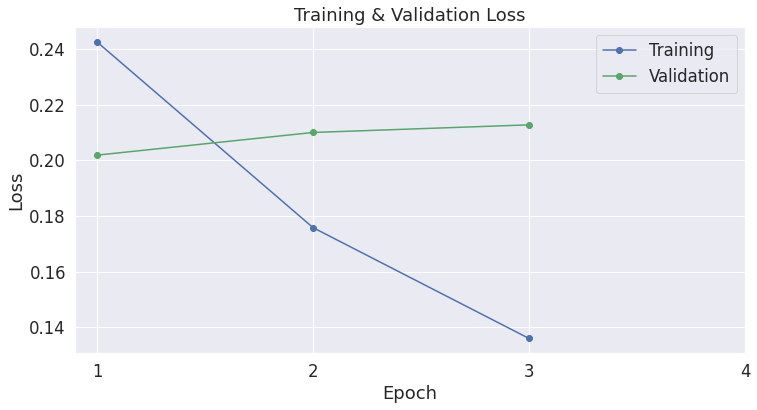

In [26]:
#'''
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()
#'''

#### 4.8.1 Validation ROC AUC

In [27]:
# Calcualte the ROC AUC score for our model's predictions.
score = roc_auc_score(flat_true_labels, flat_predictions)

print('ROC AUC: {:.4f}'.format(score))

ROC AUC: 0.9653


#### 4.8.2 Validation Precision/Recall Plot

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

n_classes = 3

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes): 
    precision[i], recall[i], _ = precision_recall_curve(ftl2[:, i], fp2[:, i]) 
    average_precision[i] = average_precision_score(ftl2[:, i], fp2[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    ftl2.ravel(), fp2.ravel()
)
average_precision["micro"] = average_precision_score(ftl2, fp2, average="micro")

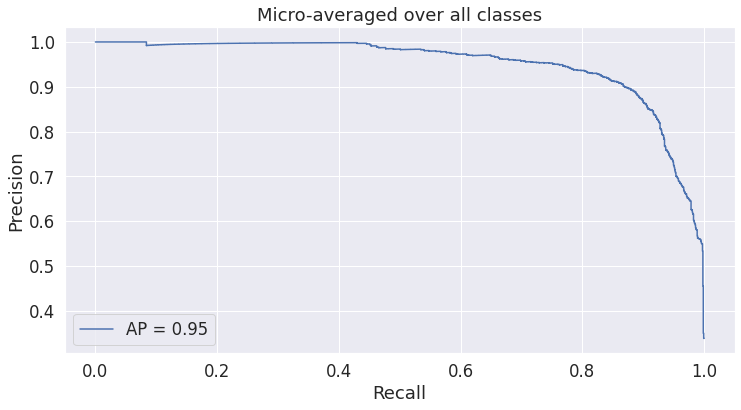

In [29]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

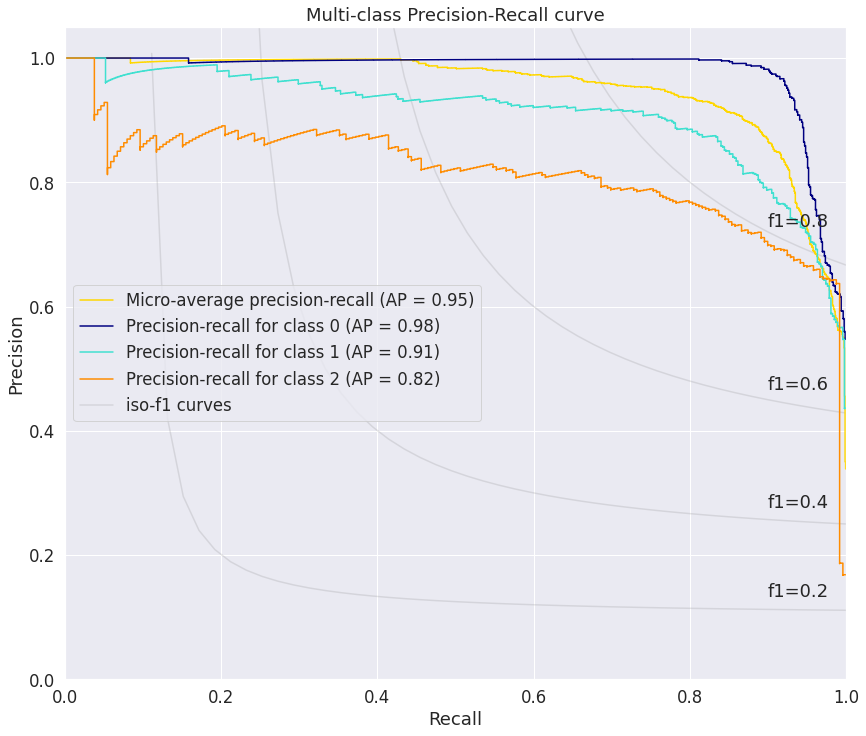

In [30]:
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import PrecisionRecallDisplay

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

#_, ax = plt.subplots(figsize=(8, 7))
_, ax = plt.subplots(figsize=(14, 12))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
#ax.set_title("Extension of Precision-Recall curve to multi-class")
ax.set_title("Multi-class Precision-Recall curve")
plt.show()

## 5 Performance On Test Set

### 5.1 Prepare Test Set

In [31]:
# Load the test set files.
test = pd.read_csv('./data/test.csv')
test_labels = pd.read_csv('./data/test_labels.csv')

print('There are {:,} total test examples.'.format(len(test)))

# The unlabeled test samples are indicated by all of the label values being
# "-1" for that sample.

# Select only the labeled test samples.

test = test[test_labels.class1 != - 1]
test_labels = test_labels.loc[test_labels.class1 != -1]

print('There are {:,} labeled test examples.'.format(len(test)))

There are 1,000 total test examples.
There are 1,000 labeled test examples.


**Tokenize & Encode** 

Encode the test set, using the same code from 3.4.

In [32]:
import torch

input_ids = []
attn_masks = []
labels = []

# ======== Encoding ========

print('Encoding all {:,} test samples...'.format(len(test)))

# For every test sample...
for (index, row) in test.iterrows():

    # Report progress.
    if ((len(input_ids) % 5000) == 0):
        print('  Tokenized {:,} comments.'.format(len(input_ids)))

    # Convert sentence pairs to input IDs, with attention masks.
    encoded_dict = tokenizer.encode_plus(row['comment_text'],  # The text to encode.
                                        max_length=max_len,    # Pad or truncate to this lenght.
                                        pad_to_max_length=True,
                                        truncation=True, 
                                        return_tensors='pt')   # Return objects as PyTorch tensors.

    # Add this example to our lists.
    input_ids.append(encoded_dict['input_ids'])
    attn_masks.append(encoded_dict['attention_mask'])
    
print('\nDONE. {:,} examples.'.format(len(input_ids)))

# ======== List of Examples --> Tensor ========

# Convert each Python list of Tensors into a 2D Tensor matrix.
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)


Encoding all 1,000 test samples...
  Tokenized 0 comments.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



DONE. 1,000 examples.


In [33]:

# ======== Prepare Labels ========

# Remove the 'id' column.
#test_labels = test_labels[['class1', 'class2', 'class3']]
del test_labels['id']

# The labels are either 0 or 1. Despite this, we need to cast the values to
# floats--otherwise our loss function will throw an error.
# https://discuss.pytorch.org/t/nn-bcewithlogitsloss-cant-accept-one-hot-target/59980
labels = test_labels.to_numpy().astype(float)

# Cast the labels list to a 2D Tensor.
labels = torch.tensor(labels)

# ======== Summary ========

print('\nData structure shapes:')
print('   input_ids:  {:}'.format(str(input_ids.shape)))
print('  attn_masks:  {:}'.format(str(attn_masks.shape)))
print('      labels:  {:}'.format(str(labels.shape)))


Data structure shapes:
   input_ids:  torch.Size([1000, 128])
  attn_masks:  torch.Size([1000, 128])
      labels:  torch.Size([1000, 3])


**DataLoader**

Create a DataLoader to batch our test samples for us.

In [34]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids, attn_masks, labels)

# Specify our batch size.
batch_size = 16

# Create the DataLoader, which will select batches for us. For testing, the
# order we evaluate the samples in doesn't matter, so we'll just use the 
# "SequentialSampler" to read them in order.
test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = SequentialSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


### 5.2 Evaluate On Test Set

In [35]:
import time

# Prediction on test set

# Put model in evaluation mode
model.eval()

t0 = time.time()

# Tracking variables 
predictions , true_labels = [], []

print('Evaluating on {:,} test set batches...'.format(len(test_dataloader)))

# Predict 
for batch in test_dataloader:
    
    # Report progress.
    if ((len(predictions) % 500) == 0):
        print('  Batch {:>5,}  of  {:>5,}.'.format(len(predictions), len(test_dataloader)))

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store the compute graph, saving memory 
    # and speeding up prediction
    with torch.no_grad():
        
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

print('Evaluation took {:.0f} seconds.'.format(time.time() - t0))

Evaluating on 63 test set batches...
  Batch     0  of     63.
    DONE.
Evaluation took 4 seconds.


In [36]:
b_labels

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], device='cuda:0', dtype=torch.float64)

We collected the predictions in batches, so now we just need to recombine them.

In [37]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)


In [38]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
testflat = np.asarray(test)

xr = len(flat_predictions)
classifications = ['BERT class, actual, confidence, test_text']
accutotal = 0

for x in range(xr):
  testtext = testflat[x,1]
  testcorrect = testflat[x,2]
  logits = flat_predictions[x]
  out = np.exp(logits) / np.sum(np.exp(logits))
  #print(out)
  #print(np.argmax(out))
  entry = [np.argmax(out), testcorrect, max(out), testtext]
  classifications.append(entry)
  # calculating accuracy
  if testcorrect == np.argmax(out):
    accutotal += 1


test3 = np.asarray(classifications)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 5.3 Score Results

Here BERT's predictions on the test set are compared to the actual classifications.

In [50]:
accuracy = format(accutotal / xr * 100, '.2f')
correct = str(accutotal)
grandtotal = str(xr)
print('The model predicted the classification of ' + correct + ' of the ' + grandtotal + ' articles correctly.')

The model predicted the classification of 902 of the 1000 articles correctly.


#### 5.3.1 Test ROC AUC

In [41]:
# Calcualte the ROC AUC score for our model's predictions.
score = roc_auc_score(flat_true_labels, flat_predictions)

print('ROC AUC: {:.4f}'.format(score))

ROC AUC: 0.9704


#### 5.3.2 Test Precision/Recall Plot

In [42]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

n_classes = 3

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes): 
    precision[i], recall[i], _ = precision_recall_curve(flat_true_labels[:, i], flat_predictions[:, i]) 
    average_precision[i] = average_precision_score(flat_true_labels[:, i], flat_predictions[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    flat_true_labels.ravel(), flat_predictions.ravel()
)
average_precision["micro"] = average_precision_score(flat_true_labels, flat_predictions, average="micro")

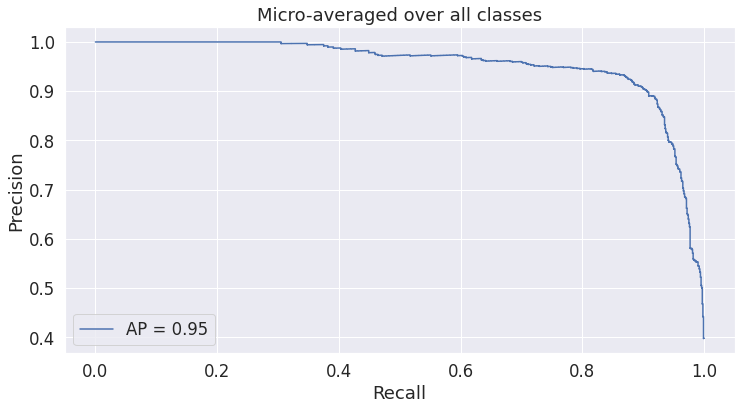

In [43]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

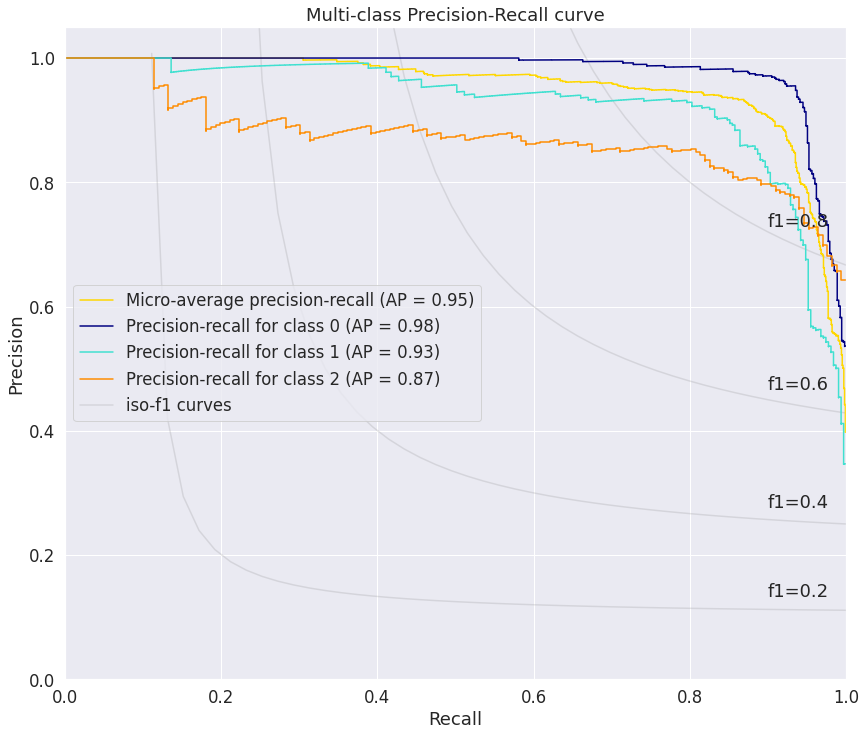

In [44]:
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import PrecisionRecallDisplay

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

#_, ax = plt.subplots(figsize=(8, 7))
_, ax = plt.subplots(figsize=(14, 12))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
#ax.set_title("Extension of Precision-Recall curve to multi-class")
ax.set_title("Multi-class Precision-Recall curve")
plt.show()

###5.4 Test Output

Here the results are output.  First is BERT's prediction, next are the actual classifications for comparison, then the score which represents the degree to which the model was certain of he classification, and finalls the actual text tested.

In [40]:
for x in range(0, xr):
  print(test3[x])

BERT class, actual, confidence, test_text
[0, 0, 0.9999841, '中共中央政治局1月12日召开会议，研究修改宪法部分内容的建议。中共中央总书记习近平主持会议。\n会议决定，中国共产党第十九届中央委员会第二次全体会议于1月18日至19日在北京召开。\n中共中央政治局听取了《中共中央关于修改宪法部分内容的建议》稿在党内外一定范围征求意见的情况报告，决定根据这次会议讨论的意见进行修改后将文件稿提请十九届二中全会审议。\n会议认为，宪法是国家的根本法，是治国安邦的总章程，是党和人民意志的集中体现。现行宪法颁布以来，在改革开放和社会主义现代化建设的历史进程中、在我们党治国理政实践中发挥了十分重要的作用。实践证明，我国现行宪法是符合国情、符合实际、符合时代发展要求的好宪法。\n会议指出，我们党高度重视宪法在治国理政中的重要地位和作用，明确坚持依法治国首先要坚持依宪治国，坚持依法执政首先要坚持依宪执政，把实施宪法摆在全面依法治国的突出位置，采取一系列有力措施加强宪法实施和监督工作，为保证宪法实施提供了强有力的政治和制度保障。\n会议认为，我国宪法以国家根本法的形式，确认了中国共产党领导中国人民进行革命、建设、改革的伟大斗争和根本成就，确立了工人阶级领导的、以工农联盟为基础的人民民主专政的社会主义国家的国体和人民代表大会制度的政体，确定了国家的根本任务、领导核心、指导思想、发展道路、奋斗目标，规定了中国共产党领导的多党合作和政治协商制度，规定了社会主义法治原则、民主集中制原则、尊重和保障人权原则等等，反映了我国各族人民共同意志和根本利益。我国宪法确立的一系列制度、原则和规则，确定的一系列大政方针，具有显著优势、坚实基础、强大生命力，必须长期坚持、全面贯彻。\n会议指出，宪法修改是国家政治生活中的一件大事，是党中央从新时代坚持和发展中国特色社会主义全局和战略高度作出的重大决策，也是推进全面依法治国、推进国家治理体系和治理能力现代化的重大举措。为更好发挥宪法在新时代坚持和发展中国特色社会主义中的重要作用，需要对宪法作出适当修改，把党和人民在实践中取得的重大理论创新、实践创新、制度创新成果上升为宪法规定。党中央决定用一次全会专门讨论宪法修改问题，充分表明党中央对这次宪法修改的高度重视。\n会议认为，这次宪法修改要高举中国特色社会主义